<span style='font-size: 2.5em'><b>Implementing a Linear Classifier from Scratch </b></span><br/>

<span style='font-size: 1.5em'>Wine recognition dataset</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Final Sprint </b></span>



### **D3APL ‚Äì Aplica√ß√µes em Ci√™ncia de Dados** (IFSP, Campinas) <br/>
**Prof**: Samuel Martins (Samuka) <br/>

#### Study Project

**Students**: Carlos Danilo Tom√© (CP3013545),
Lucas Galdino de Camargo (CP301357X)

**Dataset**: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

**Final Goal**: We aim to implement the 3 versions of the Gradient Descent (Batch, mini-batch and Stocastic) to be used as the optimizer in the Logistic Regression model to multiclass problems (the strategy chosen was One vs Rest).


---

## üéØ Notebook Goals

- 0. Imports, settings and data reading
- 1. Simplified EDA to the wine dataset
- 2. Gradient Descent Algorithm (briefly explained) and its versions
- 3. Implementation of the Batch, mini-batch and Stocastic versions of Gradient Descent as optimizer to multiclass problems (by using the "One versus Rest" strategy)
- 4. Training and comparing at least 5 different models (including the Logistic Regressor with our built optimizer), with and without fine-tuning
- 5. Conclusions and next steps

### 0. Imports, settings and data reading

In [16]:
import sklearn
from sklearn.datasets import load_wine
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from timeit import default_timer as timer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import numpy as np
from numpy import ndarray

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

In [17]:
# Data reading
data = load_wine(return_X_y=True,as_frame=True)

df = pd.concat([data[0], data[1]], axis=1)

df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

### 1. Simplified Exploratory Data Analysis (EDA) to the wine dataset

Let's take a quick look at this dataset, before we start dealing with modeling.

In resume, we've got 3 different classes of wine, and a set of characteristics from each sample (as alcohol percentage, color intensity, magnesium in the composition, etc.).

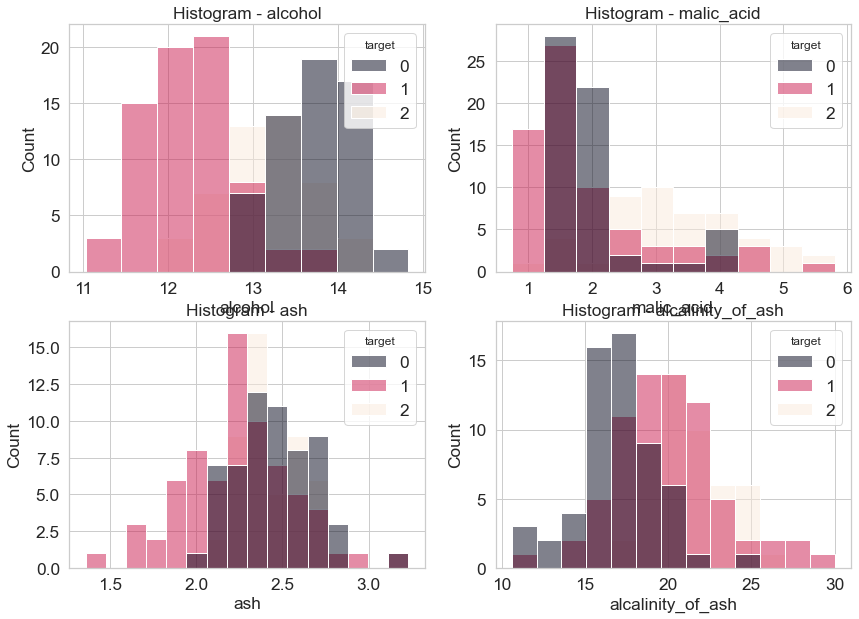

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(x="alcohol", data=df,  ax=axes[0, 0], palette ='rocket' ,hue="target")
axes[0, 0].set_title('Histogram - alcohol')

sns.histplot(x="malic_acid", data=df,  ax=axes[0, 1], palette ='rocket'  ,color = 'tab:orange',hue="target")
axes[0, 1].set_title('Histogram - malic_acid')

sns.histplot(x="ash", data=df,  ax=axes[1, 0], palette ='rocket'  ,color = 'tab:blue',hue="target")
axes[1, 0].set_title('Histogram - ash')

sns.histplot(x="alcalinity_of_ash", data=df,  ax=axes[1, 1], palette ='rocket' ,color = 'tab:orange',hue="target")
axes[1, 1].set_title('Histogram - alcalinity_of_ash');

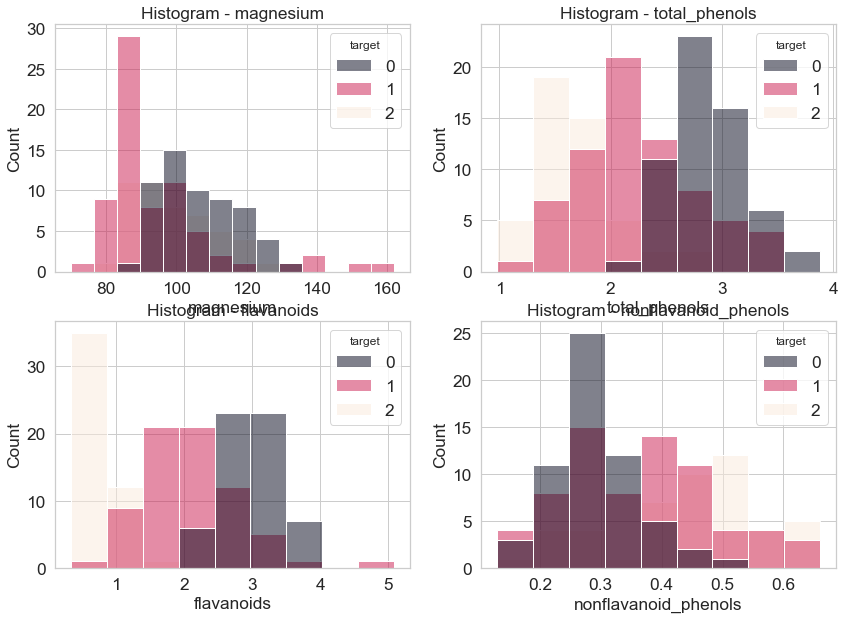

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(x="magnesium", data=df,  ax=axes[0, 0], palette ='rocket' ,hue="target")
axes[0, 0].set_title('Histogram - magnesium')

sns.histplot(x="total_phenols", data=df,  ax=axes[0, 1], palette ='rocket'  ,color = 'tab:orange',hue="target")
axes[0, 1].set_title('Histogram - total_phenols')

sns.histplot(x="flavanoids", data=df,  ax=axes[1, 0], palette ='rocket'  ,color = 'tab:blue',hue="target")
axes[1, 0].set_title('Histogram - flavanoids')

sns.histplot(x="nonflavanoid_phenols", data=df,  ax=axes[1, 1], palette ='rocket' ,color = 'tab:orange',hue="target")
axes[1, 1].set_title('Histogram - nonflavanoid_phenols');

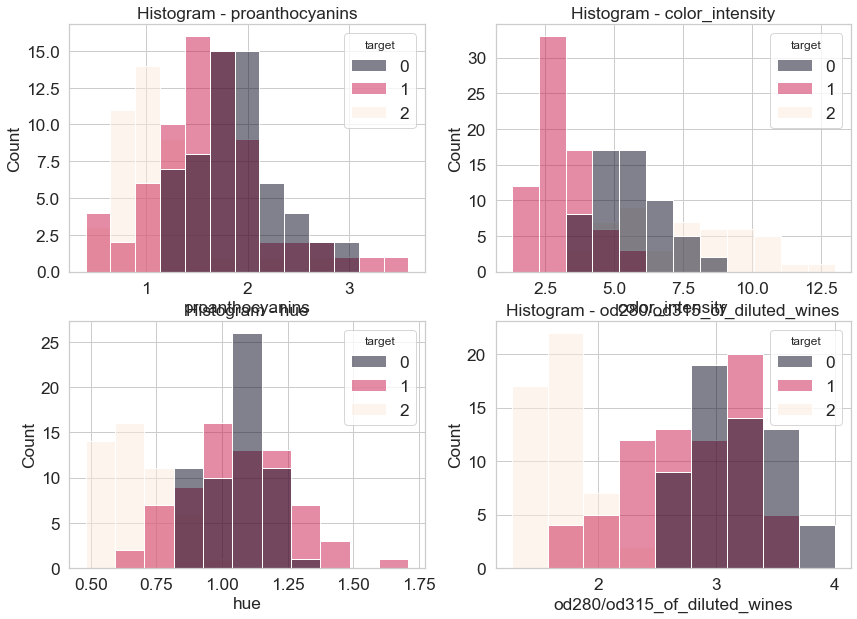

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(x="proanthocyanins", data=df,  ax=axes[0, 0], palette ='rocket' ,hue="target")
axes[0, 0].set_title('Histogram - proanthocyanins')

sns.histplot(x="color_intensity", data=df,  ax=axes[0, 1], palette ='rocket'  ,color = 'tab:orange',hue="target")
axes[0, 1].set_title('Histogram - color_intensity')

sns.histplot(x="hue", data=df,  ax=axes[1, 0], palette ='rocket'  ,color = 'tab:blue',hue="target")
axes[1, 0].set_title('Histogram - hue')

sns.histplot(x="od280/od315_of_diluted_wines", data=df,  ax=axes[1, 1], palette ='rocket' ,color = 'tab:orange',hue="target")
axes[1, 1].set_title('Histogram - od280/od315_of_diluted_wines');

Text(0.5, 1.0, 'Histogram - target')

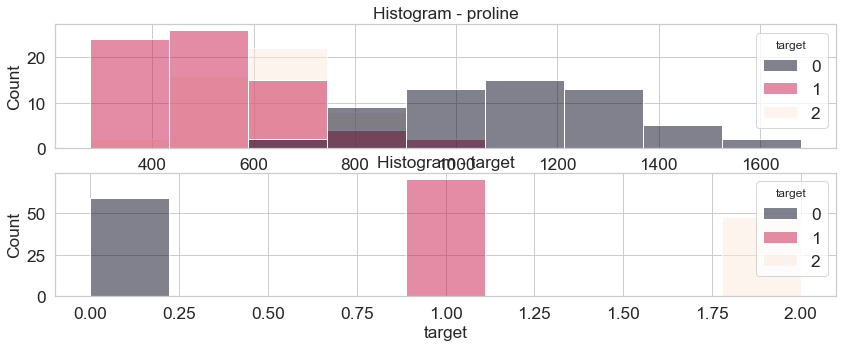

In [21]:
fig, axes = plt.subplots(2, figsize=(14,5))

sns.histplot(x="proline", data=df,  ax=axes[0], palette ='rocket' ,hue="target")
axes[0].set_title('Histogram - proline')

sns.histplot(x="target", data=df,  ax=axes[ 1], palette ='rocket'  ,color = 'tab:orange',hue="target")
axes[1].set_title('Histogram - target')

### 2. Gradient Descent Algorithm (briefly explained) and its versions

Before starting this (really simplified) explanation about the Gradient Descent, we'd like to share two links about this subject, which we found a good start to this topic.

https://machinelearningmastery.com/gradient-descent-for-machine-learning/

https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

The Gradient Descent is a well known algorithm which uses the gradient, as its own name sugests, to find minimum or maximum points in optimization problems. 

It works like that: Given a COST FUNCTION, and a STARTER POINT in the set, we compute the gradient (or the derivatives) of our cost function (in this point) in order to "walk" in the direction that minimizes (or maximizes, given the problem) our cost function. Once that's done, we'll update to the next point in this direction, and start the process over again.

The algorithm will stop: 1) when the derivatives equals to zero (and that's the optimal point), or when the derivatives are small enough (given a tollerance), or 2) when the number of iterations achieve a limit previously defined.

There are 3 different approaches of the Gradient Descent, and we'll explain them by using the multiclass wine problem we've got in this project.

Let's say we want to find the parameters of a linear classifier (like the Logistic Regressor). 
First of all, we should initialize the parameters. Next, we could try one of the following.

**BATCH**: 

Given the initialized parameters, one should do (to the whole training set), until the limit of epochs is reached (or until convergence): 

    - 1. predict the outputs
    - 2. calculate the errors
    - 3. compute the gradient
    - 4. update the parameters

In this case, we'll only update the parameters after we've done the steps 1, 2 and 3 to the entire training set.

&nbsp;

**MINI-BATCH**:

Given the initialized parameters and the batch size k, one should suffle the training set, and split it in batches of k elements. 
Next, one should repeat *for each batch of size k*, until the limit of epochs is reached (or until convergence):


    - 1. predict the outputs for the actual batch
    - 2. calculate the errors 
    - 3. compute the gradient
    - 4. update the parameters

In this case, we'll update the parameters after we've done the steps 1, 2 and 3 to the actual batch (of size *k*).

&nbsp;

**STOCHASTIC**:

Given the initialized parameters, one should shuffle the training set.
Next, one should repeat *for each observation in the training set*, until the limit of epochs is reached (or until convergence):


    - 1. predict the output for the actual training sample
    - 2. calculate the error
    - 3. compute the gradient
    - 4. update the parameters

In this case, we'll update the parameters after we've done the steps 1, 2 and 3 to the actual training sample.



&nbsp;

### 2.1 Ove Versus Rest Strategy

Just to make sure we've covered everything we aim to do in this project, we need to talk about the strategy we're going to use to the multiclass problem we've got in the wine dataset.

We've chosen the "One versus Rest" strategy, that basically consists in reducing the multiclass problem into binary class problems.

It works like that: If we've *N* different classes, we'll fit and learn *N* different classifiers (obviously, one for each class).

When assining what class a new observation we want to predict is, we'll simply assign the class where the binary classifier provided the highest probability of being from that class.


### 3. Implementation of the Batch, mini-batch and Stocastic versions of Gradient Descent as optimizer to multiclass problems (by using the "One versus Rest" strategy)

In [23]:
class LogisticRegression_Scratch(ClassifierMixin, BaseEstimator):
    """Our Logistic Regression implemented from scratch."""
    
    def __init__(self, learning_rate : float = 0.001,
                 n_epochs : int = 1000, 
                 alpha: float = 0.0001, 
                 random_state : int = 42, 
                 
                 optimizer:      str = "batch" , 
                 minibatch_size: int   = 32,
                 strategy:       str   = 'One vs Rest'                 
                ):
        """
        Parameters
        ----------
        learning_rate : float, default=0.001
            Learning rate.
            
        n_epochs : int, default=1000
            Number of epochs for training (convergence stop).
            
        alpha : float, default=0.0001
            Constant that multiplies the regularization term.
            Use 0 to ignore regularization (standard Logistic Regression).
            
        random_state : int, default=42
            Seed used for generating random numbers.

        optimizer : str, default=‚Äúbatch‚Äù
            Optimizer option of batch. Can assume 'batch', 'mini' or 'stochastic'.
            
        minibatch_size : float, default=32
        
            Learning rate.
            
        strategy : str, default='One vs Rest'
            Optimizer option of batch. Can assume 'One vs Rest' or 'One vs One'. 
            
        """
        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        assert (alpha is not None) and (alpha >= 0), \
        f'Alpha should be >= 0. Passed: {alpha}'

        assert (optimizer is not None) and ((optimizer is not 'batch') or 
                                            (optimizer is not 'mini') or 
                                            (optimizer is not 'stochastic') ), \
        f'optimizer should be batch, mini or stochastic. Passed: {optimizer}'        
        
        assert (strategy is not None) and ((strategy is not 'One vs Rest') or 
                                            (strategy is not 'One vs One') ), \
        f'strategy should be One vs One or One vs Rest. Passed: {strategy}'
        
        self.learning_rate   = learning_rate
        self.n_epochs        = n_epochs
        self.alpha           = alpha
        self.random_state    = random_state
        self.optimizer       = optimizer
        self.minibatch_size  = minibatch_size
        self.strategy        = strategy

        # parameters to be trained/learned
        self.__w = None  # weight array
        self.__b = None  # bias
    
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f'Learning rate: {self.learning_rate}\n' \
              f'Number of epochs: {self.n_epochs}\n' \
              f'Regularization constant (alpha): {self.alpha}\n' \
              f'Random state: {self.random_state}\n\n' \
              f'optimizer: {self.optimizer}\n\n' \
              f'minibatch_size: {self.minibatch_size}\n\n' \
              f'strategy: {self.strategy}\n\n' \
              f'Trained?: {self.is_fitted()}\n'
               
        return msg
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def intercept_(self) -> ndarray:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        '''Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant. 

        
        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        '''
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    
    def __gradient(self, X: ndarray, y: ndarray, p_hat: ndarray,w: ndarray, alpha: float) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        w : ndarray, shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        
        regularization = alpha * w
        
        error = p_hat - y  # shape (n_samples,)
        grad_w = (np.dot(error, X) / n_samples) + regularization  # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b      

    
    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'


        ########################################################### STRATEGY: ONE VS REST
        list_w_temp = [] # dicionario com os pesos w
        list_b_temp = [] # dicionario com os interceptos b 
        
        
        for i in np.arange(len(set(y))):

            ### finding w and b for each binary case of One vs Rest, example: 
            ### iteraction 1 : class 0 = 1 e (class 1 e class 2) = 0
            ### iteraction 2 : class 1 = 1 e (class 0 e class 2) = 0
            ### iteraction 3 : class 2 = 1 e (class 0 e class 1) = 0
            ### mapping target y for each binary case 
            y_temp = np.where(y == i ,1 ,0)
            
            
            ### SETTING SEED
            np.random.seed(self.random_state)
            n_samples, n_features = X.shape

            ### PARAMETER INITIALIZATION
            # return values from the ‚Äústandard normal‚Äù distribution.
            w = np.random.randn(n_features)  # shape: (n_features,)
            b = 0.0

            # array that stores the loss of each epoch
            losses = []

            # LEARNING ITERATIONS
            for epoch in np.arange(self.n_epochs):

                X_new, y_new = None, None

                ###########################################################                 
                if self.optimizer == 'batch':
                                       
                    ############################# estimation_forward_pass

                    z = np.dot(X, w) + b  # shape: (n_samples,)
                    p_hat = self.__sigmoid(z)

                    loss_epoch = self.__log_loss(y_temp, p_hat)
                    losses.append(loss_epoch)


                    ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                    # grad_w.shape: (n_features,)
                    # grad_b: float
                    grad_w, grad_b = self.__gradient(X, y_temp, p_hat, w, self.alpha)
                    w = w - self.learning_rate * grad_w  # shape: (n_features)
                    b = b - self.learning_rate * grad_b  # float
                        
                       
                ###########################################################  
                if self.optimizer == 'mini':

                    # Shuffle data
                    X_new, y_new = shuffle(X, y_temp)
                    
                    
                    # Calculate the number of groups that we will iterate
                    number_of_batch = int(n_samples/self.minibatch_size) 

                    # for each mini_batch in our data calculeted and update losses, gradient, w and b
                    for i in range(0,number_of_batch): 
                        
                        ############################# Mapping mini batch
                        start_index = i * number_of_batch
                        end_index   = (i + 1)*number_of_batch

                        mini_batch_X = X[ start_index: end_index, :]
                        mini_batch_y = y_temp[ start_index: end_index]

                        ############################# estimation_forward_pass

                        z = np.dot(mini_batch_X, w) + b  # shape: (n_samples,)
                        p_hat = self.__sigmoid(z)

                        loss_epoch = self.__log_loss(mini_batch_y, p_hat)
                        losses.append(loss_epoch)


                        ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                        # grad_w.shape: (n_features,)
                        # grad_b: float
                        grad_w, grad_b = self.__gradient(mini_batch_X, mini_batch_y, p_hat, w, self.alpha)
                        w = w - self.learning_rate * grad_w  # shape: (n_features)
                        b = b - self.learning_rate * grad_b  # float



                ###########################################################              
                if self.optimizer == 'stochastic':

                    # Shuffle data
                    X_new, y_new = shuffle(X, y_temp)

                    # for each sample in our data calculeted and update losses, gradient, w and b
                    for i in range(0,n_samples):   

                        ############################# estimation_forward_pass

                        z = np.dot(X_new[i], w) + b  # shape: (n_samples,)
                        p_hat = self.__sigmoid(z)
                        loss_epoch = self.__log_loss(y_new[i], p_hat)
                        losses.append(loss_epoch)


                        ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                        # grad_w.shape: (n_features,)
                        # grad_b: float
                        grad_w, grad_b = self.__gradient(X_new[i], y_new[i], p_hat, w, self.alpha)
                        w = w - self.learning_rate * grad_w  # shape: (n_features)
                        b = b - self.learning_rate * grad_b  # float
                
                if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                    print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={loss_epoch:.7f}')                       
       

            
            # keep and append each w[i] for the i-th One vs Rest iteration
            list_w_temp.append(w)
            list_b_temp.append(b)
                
        if verbose:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
                

        ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
        self.__w = list_w_temp
        self.__b = list_b_temp

    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,n_class)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        
        # Create a empty list of probabilites 
        p_hat = []

        for i in range(0, 3):
            
            # Roda o produto interno somente para a classe em quest√£o
            w_temp = self.__w[i]
            b_temp = self.__b[i]
           
            z = np.dot(X, w_temp) + b_temp
            
            phat_temp = self.__sigmoid(z)
            p_hat.append(phat_temp)
        
        return p_hat
    
        
        
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
                            
        p_hat = self.predict_proba(X)
        p_hat = np.matrix(p_hat)
        
        list_predict = []

        for index in range(0, p_hat.T.shape[0] ):
            
            # get the maximum probability value by row
            maximum = p_hat.T[index].max()
            
            # Check the maximum probability for each binary case
            predict_class = p_hat.T[index].tolist()[0].index(maximum)

            list_predict.append(predict_class)
        
        return list_predict

### 4. Training and comparing at least 5 different models (including the Logistic Regressor with our built optimizer), with and without fine-tuning

In [24]:
# Splitting the target variable from our original dataset
X = df.drop('target', axis=1)
y = df['target']

# In order to train our models, we're going to standardize our features with Standard Scaler
scaler = StandardScaler()

# Splitting the data into train and test (to future model evaluation and comparison)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=42 )

# Scaler Data 
X_treino = scaler.fit_transform(X_treino)
X_teste  = scaler.transform(X_teste)

# Generating our folds in order to do cross validation 
cv = KFold(4, shuffle=True, random_state=0)

In [25]:
# Function to evaluete multi class metrics of performance for the models

def multi_class_results(modelo, nome_do_modelo):
      
    resultado = modelo.predict(X_teste)
       
    acuracia  =  accuracy_score(y_teste,resultado)
    f1        =  f1_score(y_teste, resultado, average='micro') 
    precisao  =  precision_score(y_teste, resultado, average='macro')
    recall    =  recall_score(y_teste,resultado, average='macro')
    
    print('Acuracia                     : ', acuracia*100, '%'  )
    print('F1 Score                     : ', f1  )
    print('Precis√£o (Precision)         : ', precisao )
    print('Recall                       : ', recall  )
   
    disp = plot_confusion_matrix(modelo, X_teste, y_teste, cmap=plt.cm.Blues)

Model 1.0 - LogisticRegression default version

Acuracia                     :  97.77777777777777 %
F1 Score                     :  0.9777777777777777
Precis√£o (Precision)         :  0.9743589743589745
Recall                       :  0.9814814814814815
Training time model: 0.2300717999999904 seconds


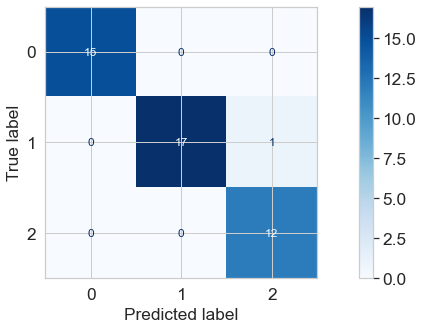

In [26]:
print("Model 1.0 - LogisticRegression default version\n") 

# Create sklearn model object
modelo = LogisticRegression()

start = timer()

# Train Model
modelo.fit(X_treino, y_treino)

multi_class_results(modelo, 'LogisticRegression')


end = timer()
print('Training time model:',end - start, 'seconds')


Model 1.1 - LogisticRegression with fine tuning 

Best parameters: 
 {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag'} 

Acuracia                     :  97.77777777777777 %
F1 Score                     :  0.9777777777777777
Precis√£o (Precision)         :  0.9743589743589745
Recall                       :  0.9814814814814815
Training time model: 3.3161231999999927 seconds


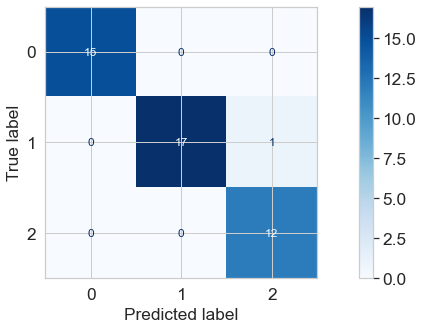

In [27]:
print("Model 1.1 - LogisticRegression with fine tuning \n") 

# Cria dicionario com os parametros do modelo
parametros = {'multi_class': ['auto', 'ovr', 'multinomial'],
              'penalty': ["l2",'elasticnet', "none"],
              'solver': [ 'sag', 'saga','lbfgs', 'liblinear'],
              'max_iter':[100,250,500,1000,2000] 
}

# Create sklearn model object
modelo = LogisticRegression()

# GridSearch
grid = GridSearchCV(modelo,parametros,cv=cv, scoring = 'f1', n_jobs = -1)


start = timer()

# Train Model
grid.fit(X_treino, y_treino)

# Get best model
melhor_regressao_logistica = grid.best_estimator_

print('Best parameters: \n',grid.best_params_, '\n')

multi_class_results(melhor_regressao_logistica, 'LogisticRegression')

end = timer()
print('Training time model:',end - start, 'seconds')

Model 2.0 - SGDClassifier default version

Acuracia                     :  97.77777777777777 %
F1 Score                     :  0.9777777777777777
Precis√£o (Precision)         :  0.9743589743589745
Recall                       :  0.9814814814814815
Training time model: 0.05044429999998101 seconds


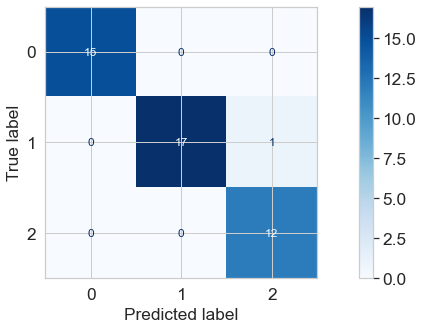

In [28]:
print("Model 2.0 - SGDClassifier default version\n") 

# Create sklearn model object
modelo = SGDClassifier(loss='log')

start = timer()

# Train model
modelo.fit(X_treino, y_treino)

multi_class_results(modelo, 'SGDClassifier')

end = timer()
print('Training time model:',end - start, 'seconds')

Model 2.1 - SGDClassifier with fine tuning

Melhores parametros encontrados: 
 {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'} 

Acuracia                     :  97.77777777777777 %
F1 Score                     :  0.9777777777777777
Precis√£o (Precision)         :  0.9743589743589745
Recall                       :  0.9814814814814815
Training time model: 0.12073629999997593 seconds


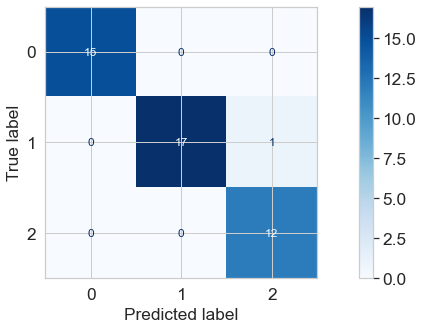

In [29]:
print("Model 2.1 - SGDClassifier with fine tuning\n") 

# Cria dicionario com os parametros do modelo
parametros = {'penalty': [ 'l1',"l2",'elasticnet', "none"],
              'loss': ['log'],
              'alpha': [0.001, 0.01, 0.1],

}

# Create sklearn model object
modelo = SGDClassifier()

# GridSearch
grid = GridSearchCV(modelo,parametros,cv=cv, scoring = 'f1', n_jobs = -1)

start = timer()

# Train model
grid.fit(X_treino, y_treino)

# Get best model
melhor_regressao_logistica = grid.best_estimator_

print('Melhores parametros encontrados: \n',grid.best_params_, '\n')

multi_class_results(melhor_regressao_logistica, 'LogisticRegression')

end = timer()
print('Training time model:',end - start, 'seconds')

Model 3.0 - LogisticRegression from Scratch

Acuracia                     :  95.55555555555556 %
F1 Score                     :  0.9555555555555556
Precis√£o (Precision)         :  0.9523809523809524
Recall                       :  0.9629629629629629
Training time model: 0.1833199999999806 seconds


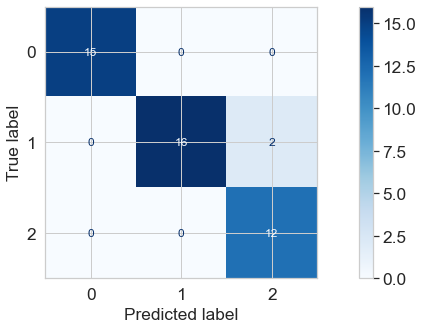

In [30]:
print("Model 3.0 - LogisticRegression from Scratch\n") 

# inicialize model object
modelo = LogisticRegression_Scratch()

start = timer()

# Train model
modelo.fit(X_treino, y_treino)

multi_class_results(modelo, 'LogisticRegression')

end = timer()
print('Training time model:',end - start, 'seconds')

Model 3.1 - LogisticRegression with fine tuning

Melhores parametros encontrados: 
 {'alpha': 0.01, 'minibatch_size': 32, 'n_epochs': 500, 'optimizer': 'batch'} 

Acuracia                     :  95.55555555555556 %
F1 Score                     :  0.9555555555555556
Precis√£o (Precision)         :  0.9523809523809524
Recall                       :  0.9629629629629629
Training time model: 200.9319538 seconds


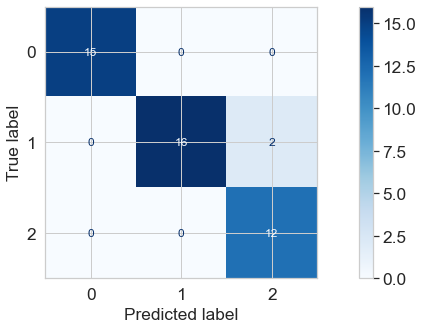

In [31]:
print("Model 3.1 - LogisticRegression with fine tuning\n") 

# Cria dicionario com os parametros do modelo
parametros = {'n_epochs':[500, 1000],
              'alpha': [0.01, 0.1, 100, 1000,1500],
              'optimizer': ['batch', 'mini', 'stochastic'],
              'minibatch_size':[32,64] 
}

# inicialize model object
modelo = LogisticRegression_Scratch()

# GridSearch
grid = GridSearchCV(modelo,parametros,cv=cv, scoring = 'f1', n_jobs = -1)

start = timer()

# Train model
grid.fit(X_treino, y_treino)

# Get best model
melhor_regressao_logistica = grid.best_estimator_

print('Melhores parametros encontrados: \n',grid.best_params_, '\n')

multi_class_results(melhor_regressao_logistica, 'LogisticRegression')

end = timer()
print('Training time model:',end - start, 'seconds')

In [32]:
melhor_regressao_logistica

LogisticRegression_Scratch(alpha=0.01, n_epochs=500)

### 5. Conclusions and next steps

#### 5.1 Results


| Model                                            | Acuraccy  | F1        | Time (s) |
|--------------------------------------------------|-----------|-----------|----------|
| Model 1.0 - LogisticRegression default version   | 97.77     | 97.77     | 0.13     |
| Modelo 1.1 - LogisticRegression with fine tuning | 97.77     | 97.77     | 8.52     |
| Modelo 2.0 - SGDClassifier default version       | 97.77     | 97.77     | 0.07     |
| Modelo 2.1 - SGDClassifier with fine tuning      | 97.77     | 97.77     | 0.46     |
| Modelo 3.0 - LogisticRegression from Scratch     | 95.55     | 95.55     | 0.45     |
| Modelo 3.1 - LogisticRegression with fine tuning | 95.55     | 95.55     | 200.00   |

#### 5.2 Conclusions




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f95e5b64-65bc-4d06-9906-e2792cd739b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>